In [1]:
import numpy as np
import pandas as pd
import warnings

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [3]:
train_df.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [4]:
test_df.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,517754,highway,2,0.34,45,night,clear,True,True,afternoon,True,True,1
1,517755,urban,3,0.04,45,dim,foggy,True,False,afternoon,True,False,0
2,517756,urban,2,0.59,35,dim,clear,True,False,afternoon,True,True,1
3,517757,rural,4,0.95,35,daylight,rainy,False,False,afternoon,False,False,2
4,517758,highway,2,0.86,35,daylight,clear,True,False,evening,False,True,3


In [5]:
train_df.isna().sum() , test_df.isna().sum()

(id                        0
 road_type                 0
 num_lanes                 0
 curvature                 0
 speed_limit               0
 lighting                  0
 weather                   0
 road_signs_present        0
 public_road               0
 time_of_day               0
 holiday                   0
 school_season             0
 num_reported_accidents    0
 accident_risk             0
 dtype: int64,
 id                        0
 road_type                 0
 num_lanes                 0
 curvature                 0
 speed_limit               0
 lighting                  0
 weather                   0
 road_signs_present        0
 public_road               0
 time_of_day               0
 holiday                   0
 school_season             0
 num_reported_accidents    0
 dtype: int64)

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

In [7]:
train_df.describe()

,id,num_lanes,curvature,speed_limit,num_reported_accidents,accident_risk
count,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000
mean,258876.500000,2.491511,0.488719,46.112575,1.187970,0.352377
std,149462.849975,1.120434,0.272563,15.788521,0.895961,0.166417
min,0.000000,1.000000,0.000000,25.000000,0.000000,0.000000
25%,129438.250000,1.000000,0.260000,35.000000,1.000000,0.230000
50%,258876.500000,2.000000,0.510000,45.000000,1.000000,0.340000
75%,388314.750000,3.000000,0.710000,60.000000,2.000000,0.460000
max,517753.000000,4.000000,1.000000,70.000000,7.000000,1.000000


In [8]:
from scipy.stats import zscore
from scipy.spatial.distance import mahalanobis

In [9]:
df = train_df.select_dtypes(include=[np.number]).copy()

In [10]:
def detect_outliers_iqr(df):
    outlier_index = set()

    for col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        idx = df[(df[col] < lower) | (df[col] > upper)].index
        outlier_index.update(idx)

    return list(outlier_index)

iqr_outliers = detect_outliers_iqr(df)
print("IQR Outliers:", len(iqr_outliers))

IQR Outliers: 5224


In [11]:
def detect_outliers_zscore(df, threshold=3):
    z_scores = np.abs(zscore(df))
    outlier_rows = np.where(z_scores > threshold)[0]
    return np.unique(outlier_rows)

z_outliers = detect_outliers_zscore(df)
print("Z-score Outliers:", len(z_outliers))

Z-score Outliers: 3452


In [12]:
def detect_outliers_mahalanobis(df, threshold=3.5):
    data = df.values
    mean_vec = np.mean(data, axis=0)
    cov_matrix = np.cov(data, rowvar=False)
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    distances = []
    for x in data:
        d = mahalanobis(x, mean_vec, inv_cov_matrix)
        distances.append(d)

    distances = np.array(distances)
    outlier_idx = np.where(distances > threshold)[0]

    return outlier_idx, distances

m_outliers, m_distances = detect_outliers_mahalanobis(df)
print("Mahalanobis Outliers:", len(m_outliers))

Mahalanobis Outliers: 9935


In [13]:
common_outliers = set(iqr_outliers) & set(z_outliers) & set(m_outliers)
len(common_outliers)


3345

In [14]:
# Remove common outliers from the dataframe
clean_df = train_df.drop(index=list(common_outliers)).reset_index(drop=True)

print("Original shape:", train_df.shape)
print("Cleaned shape:", clean_df.shape)
print("Removed rows:", len(common_outliers))


Original shape: (517754, 14)
Cleaned shape: (514409, 14)
Removed rows: 3345


In [15]:
num_df = clean_df.select_dtypes(include=[np.number])

In [16]:
skew_vals = num_df.skew()
skewed_cols = skew_vals[abs(skew_vals) > 0.5].index.tolist()

print("Columns needing transformation:", skewed_cols)

Columns needing transformation: []


In [17]:
clean_df.duplicated().sum()


np.int64(0)

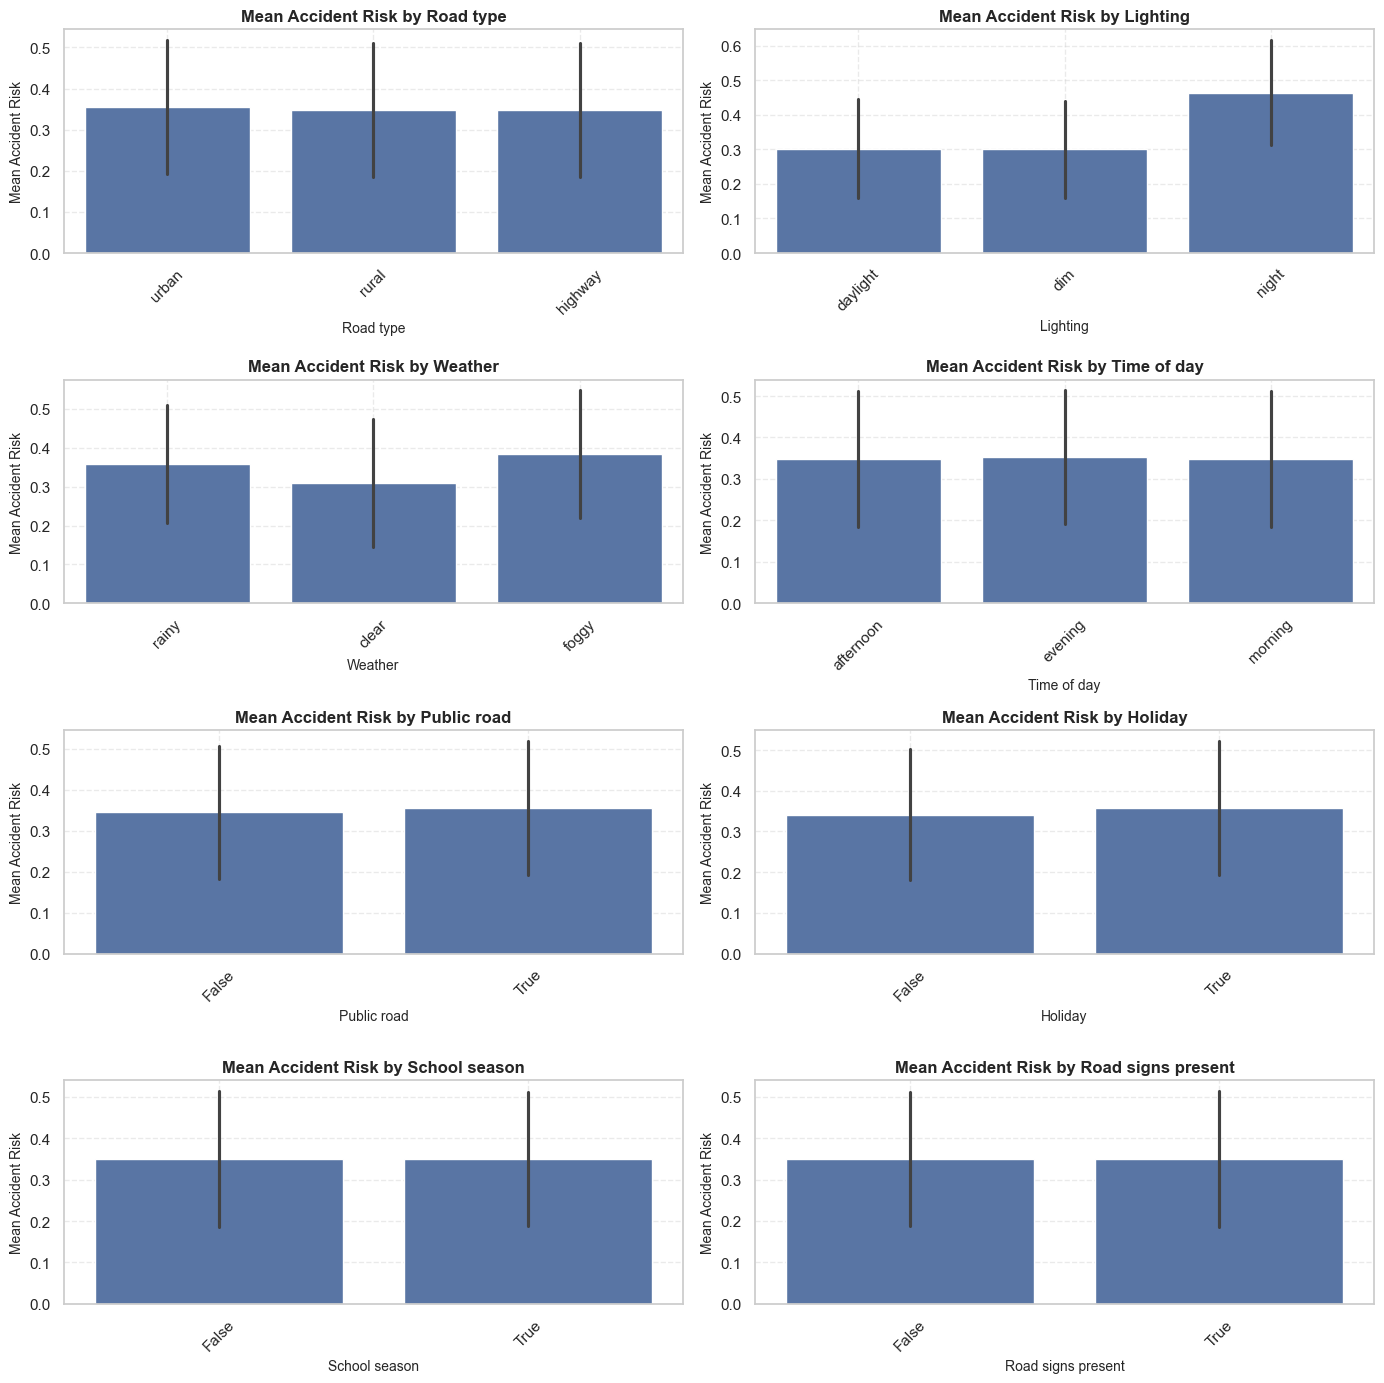

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

cat_features = [
    'road_type', 'lighting', 'weather', 'time_of_day',
    'public_road', 'holiday', 'school_season', 'road_signs_present'
]

fig, axes = plt.subplots(4, 2, figsize=(14, 14))
axes = axes.flatten()

for i, col in enumerate(cat_features):
    sns.barplot(
        x=col,
        y='accident_risk',
        data=clean_df,
        estimator='mean',
        errorbar='sd',
        ax=axes[i]
    )
    axes[i].set_title(f"Mean Accident Risk by {col.replace('_', ' ').capitalize()}", fontsize=12, weight='bold')
    axes[i].set_xlabel(col.replace('_', ' ').capitalize(), fontsize=10)
    axes[i].set_ylabel("Mean Accident Risk", fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

In [19]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

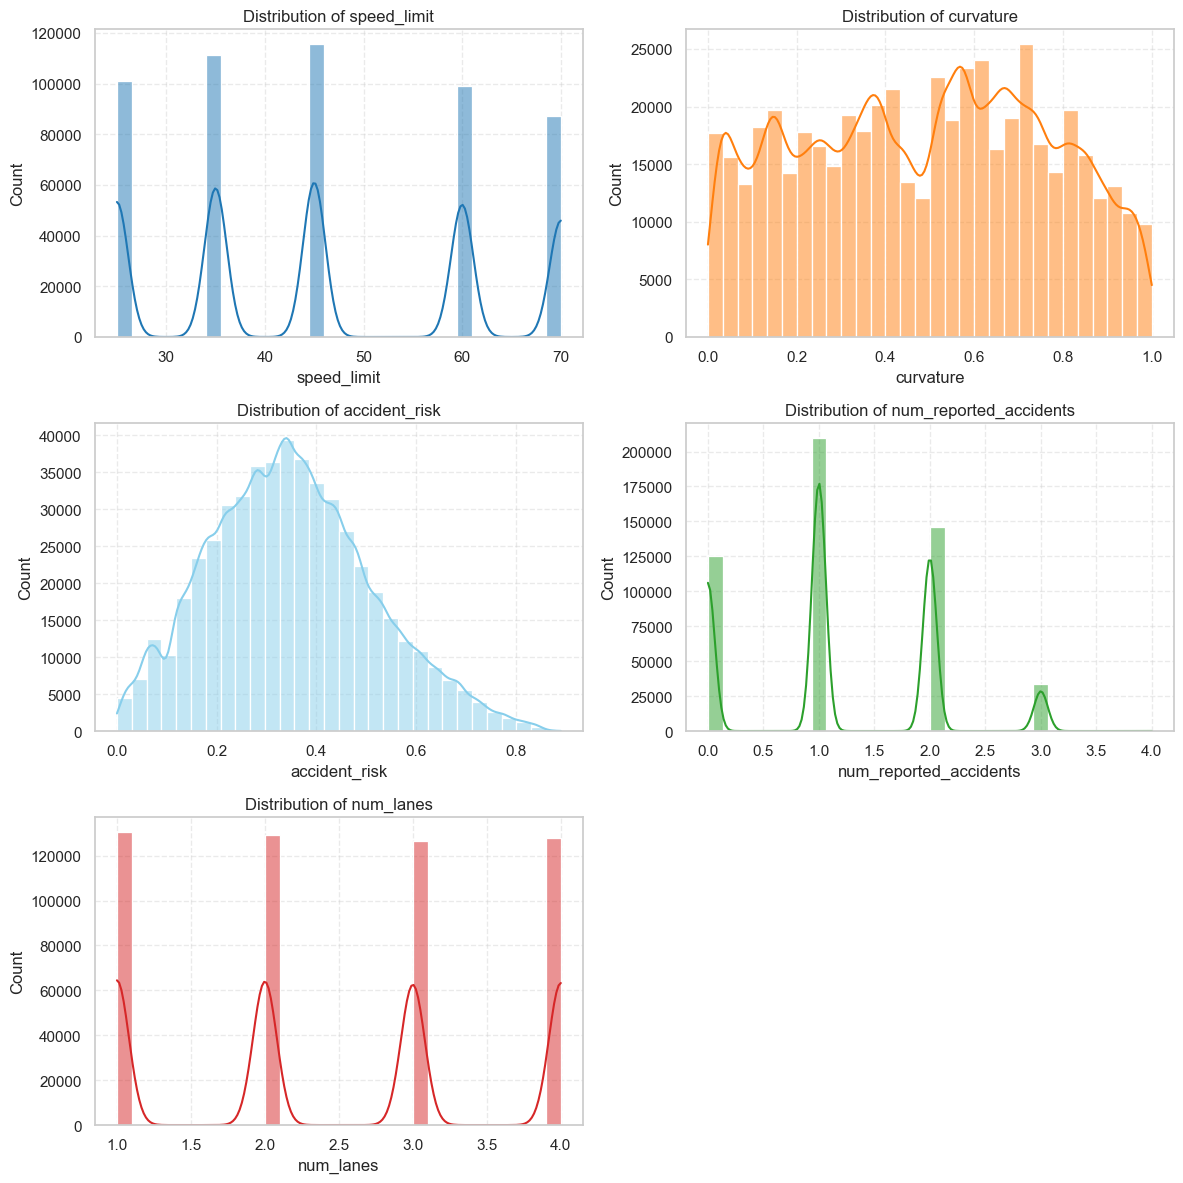

In [20]:
num_features = [
    'speed_limit', 'curvature', 'accident_risk',
    'num_reported_accidents', 'num_lanes'
]

colors = ['#1f77b4', '#ff7f0e', '#87ceeb', '#2ca02c', '#d62728']

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

for i, col in enumerate(num_features):
    sns.histplot(clean_df[col], bins=30, kde=True, color=colors[i], ax=axes[i])
    axes[i].set_title(f"Distribution of {col}", fontsize=12)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
    axes[i].grid(True, linestyle='--', alpha=0.4)

fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

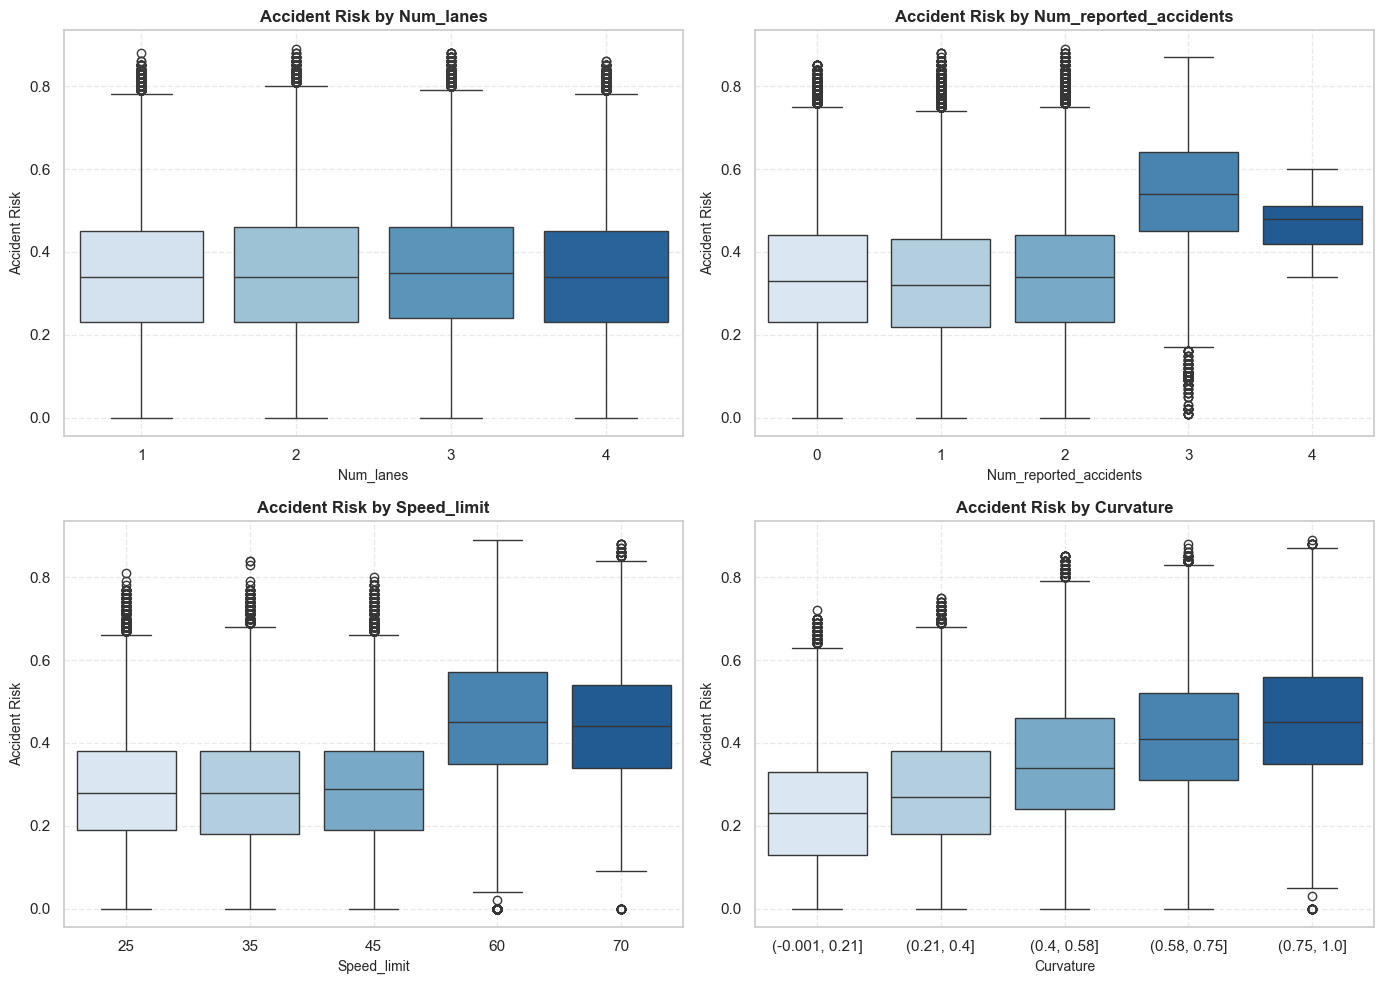

In [21]:
sns.set_theme(style="whitegrid")

discrete_features = ['num_lanes', 'num_reported_accidents', 'speed_limit']
continuous_features = ['curvature']
all_features = discrete_features + continuous_features

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(all_features):
    if col in continuous_features:
        # Bin continuous feature into 5 quantiles
        clean_df[f'{col}_bin'] = pd.qcut(clean_df[col], q=5, duplicates='drop')
        x_col = f'{col}_bin'
    else:
        x_col = col  # Use discrete feature as is

    sns.boxplot(
        x=x_col,
        y='accident_risk',
        data=clean_df,
        ax=axes[i],
        palette="Blues"
    )

    axes[i].set_title(f"Accident Risk by {col.capitalize()}", fontsize=12, weight='bold')
    axes[i].set_xlabel(col.capitalize(), fontsize=10)
    axes[i].set_ylabel("Accident Risk", fontsize=10)
    axes[i].tick_params(axis='x')
    axes[i].grid(True, linestyle='--', alpha=0.4)

for j in range(len(all_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [22]:
from scipy.optimize import minimize

def neg_corr(weights, df):
    w_curv, w_light, w_weather, w_speed, w_acc = weights
    
    risk = (
        w_curv   * df['curvature'] +
        w_light  * (df['lighting'] == "night").astype(int) +  # lighting == "night"
        w_weather* (df["weather"] != "clear").astype(int) +     # weather != "clear"
        w_speed  * (df['speed_limit'] >= 60).astype(int) +
        w_acc    * (df['num_reported_accidents'] > 2).astype(int)
    )
    
    return -np.corrcoef(risk, df['accident_risk'])[0, 1]

bounds = [(0, 1)] * 5

np.random.seed(42)
random_start = np.random.rand(5)

result = minimize(
    neg_corr,
    random_start,
    args=(clean_df,),
    bounds=bounds
)

best_weights = result.x

feature_names = ['curvature', 'lighting', 'weather', 'speed_limit', 'num_reported_accidents']
print("Coefficients optimaux :")
for name, w in zip(feature_names, best_weights):
    print(f"{name}: {w:.3f}")

final_corr = -neg_corr(best_weights, clean_df)
print(f"\nCorrelation : {final_corr:.3f}")

Coefficients optimaux :
curvature: 0.999
lighting: 0.622
weather: 0.305
speed_limit: 0.612
num_reported_accidents: 0.317

Correlation : 0.936


In [23]:
best_weights = np.array([0.999, 0.622, 0.305, 0.611, 0.317])
normalized_weights = np.round(best_weights / 3, 1)

for name, w in zip(['curvature','lighting','weather','speed_limit','num_reported_accidents'], normalized_weights):
    print(f"{name}: {w}")

curvature: 0.3
lighting: 0.2
weather: 0.1
speed_limit: 0.2
num_reported_accidents: 0.1


In [24]:
def compute_base_risk(df):
    return (
        0.3 * df["curvature"] +
        0.2 * (df["lighting"] == "night").astype(int) +
        0.1 * (df["weather"] != "clear").astype(int) +
        0.2 * (df["speed_limit"] >= 60).astype(int) +
        0.1 * (np.array(df["num_reported_accidents"]) > 2).astype(int)
    )

clean_df["base_risk"] = compute_base_risk(clean_df)
test_df["base_risk"] = compute_base_risk(test_df)

In [25]:
categorical_cols = ['weather','road_type','time_of_day']
clean_df = pd.get_dummies(clean_df, columns=categorical_cols, drop_first=False)
test_df = pd.get_dummies(test_df, columns=categorical_cols, drop_first=False)

lighting_mapping = {'daylight': 0, 'dim': 0, 'night': 1}
clean_df['lighting_encoded'] = clean_df['lighting'].map(lighting_mapping)
test_df['lighting_encoded'] = test_df['lighting'].map(lighting_mapping)

binary_cols = ['holiday','school_season','road_signs_present','public_road']
for col in binary_cols:
    clean_df[col] = clean_df[col].astype(int)
    test_df[col] = test_df[col].astype(int)

In [26]:
test_ids = test_df['id']

clean_df = clean_df.drop(columns=['id'])
test_df = test_df.drop(columns=['id'])

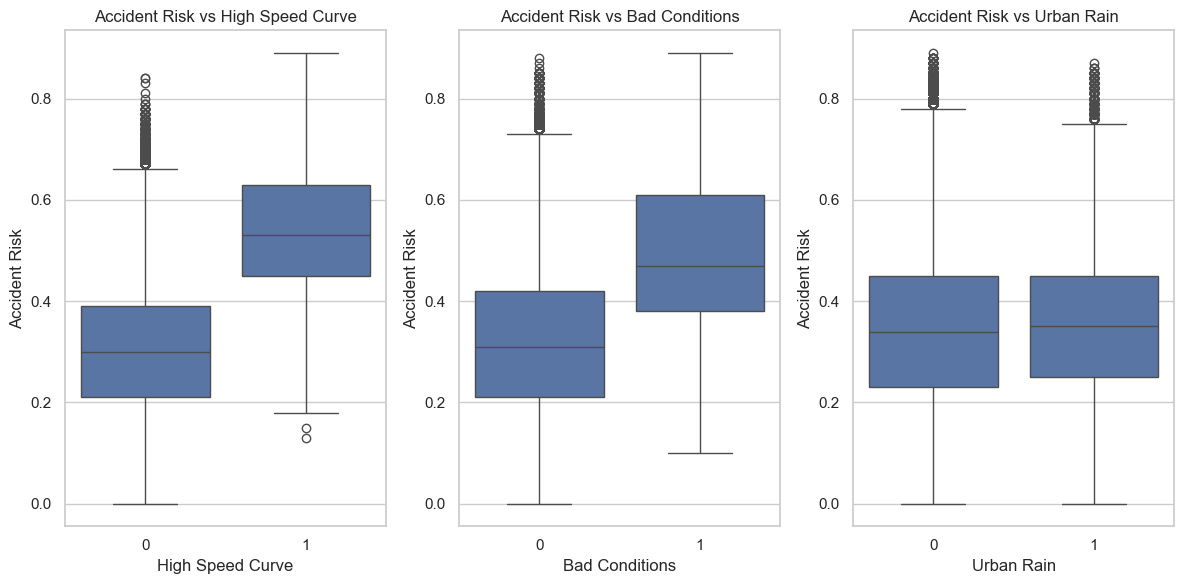

In [27]:
binary_features = {
    'High Speed Curve': (clean_df['speed_limit'] >= 60) & (clean_df['curvature'] > 0.5),
    'Bad Conditions': ((clean_df.get('weather_rainy',0) == 1) | (clean_df.get('weather_foggy',0) == 1)) & (clean_df['lighting_encoded'] == 1),
    'Urban Rain': (clean_df.filter(like='road_type_urban').max(axis=1) == 1) & (clean_df.get('weather_rainy',0) == 1),
}

plt.figure(figsize=(12,6))

for i, (name, feature) in enumerate(binary_features.items(), 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x=feature.astype(int), y=clean_df['accident_risk'])
    plt.title(f"Accident Risk vs {name}")
    plt.xlabel(name)
    plt.ylabel("Accident Risk")

plt.tight_layout()
plt.show()

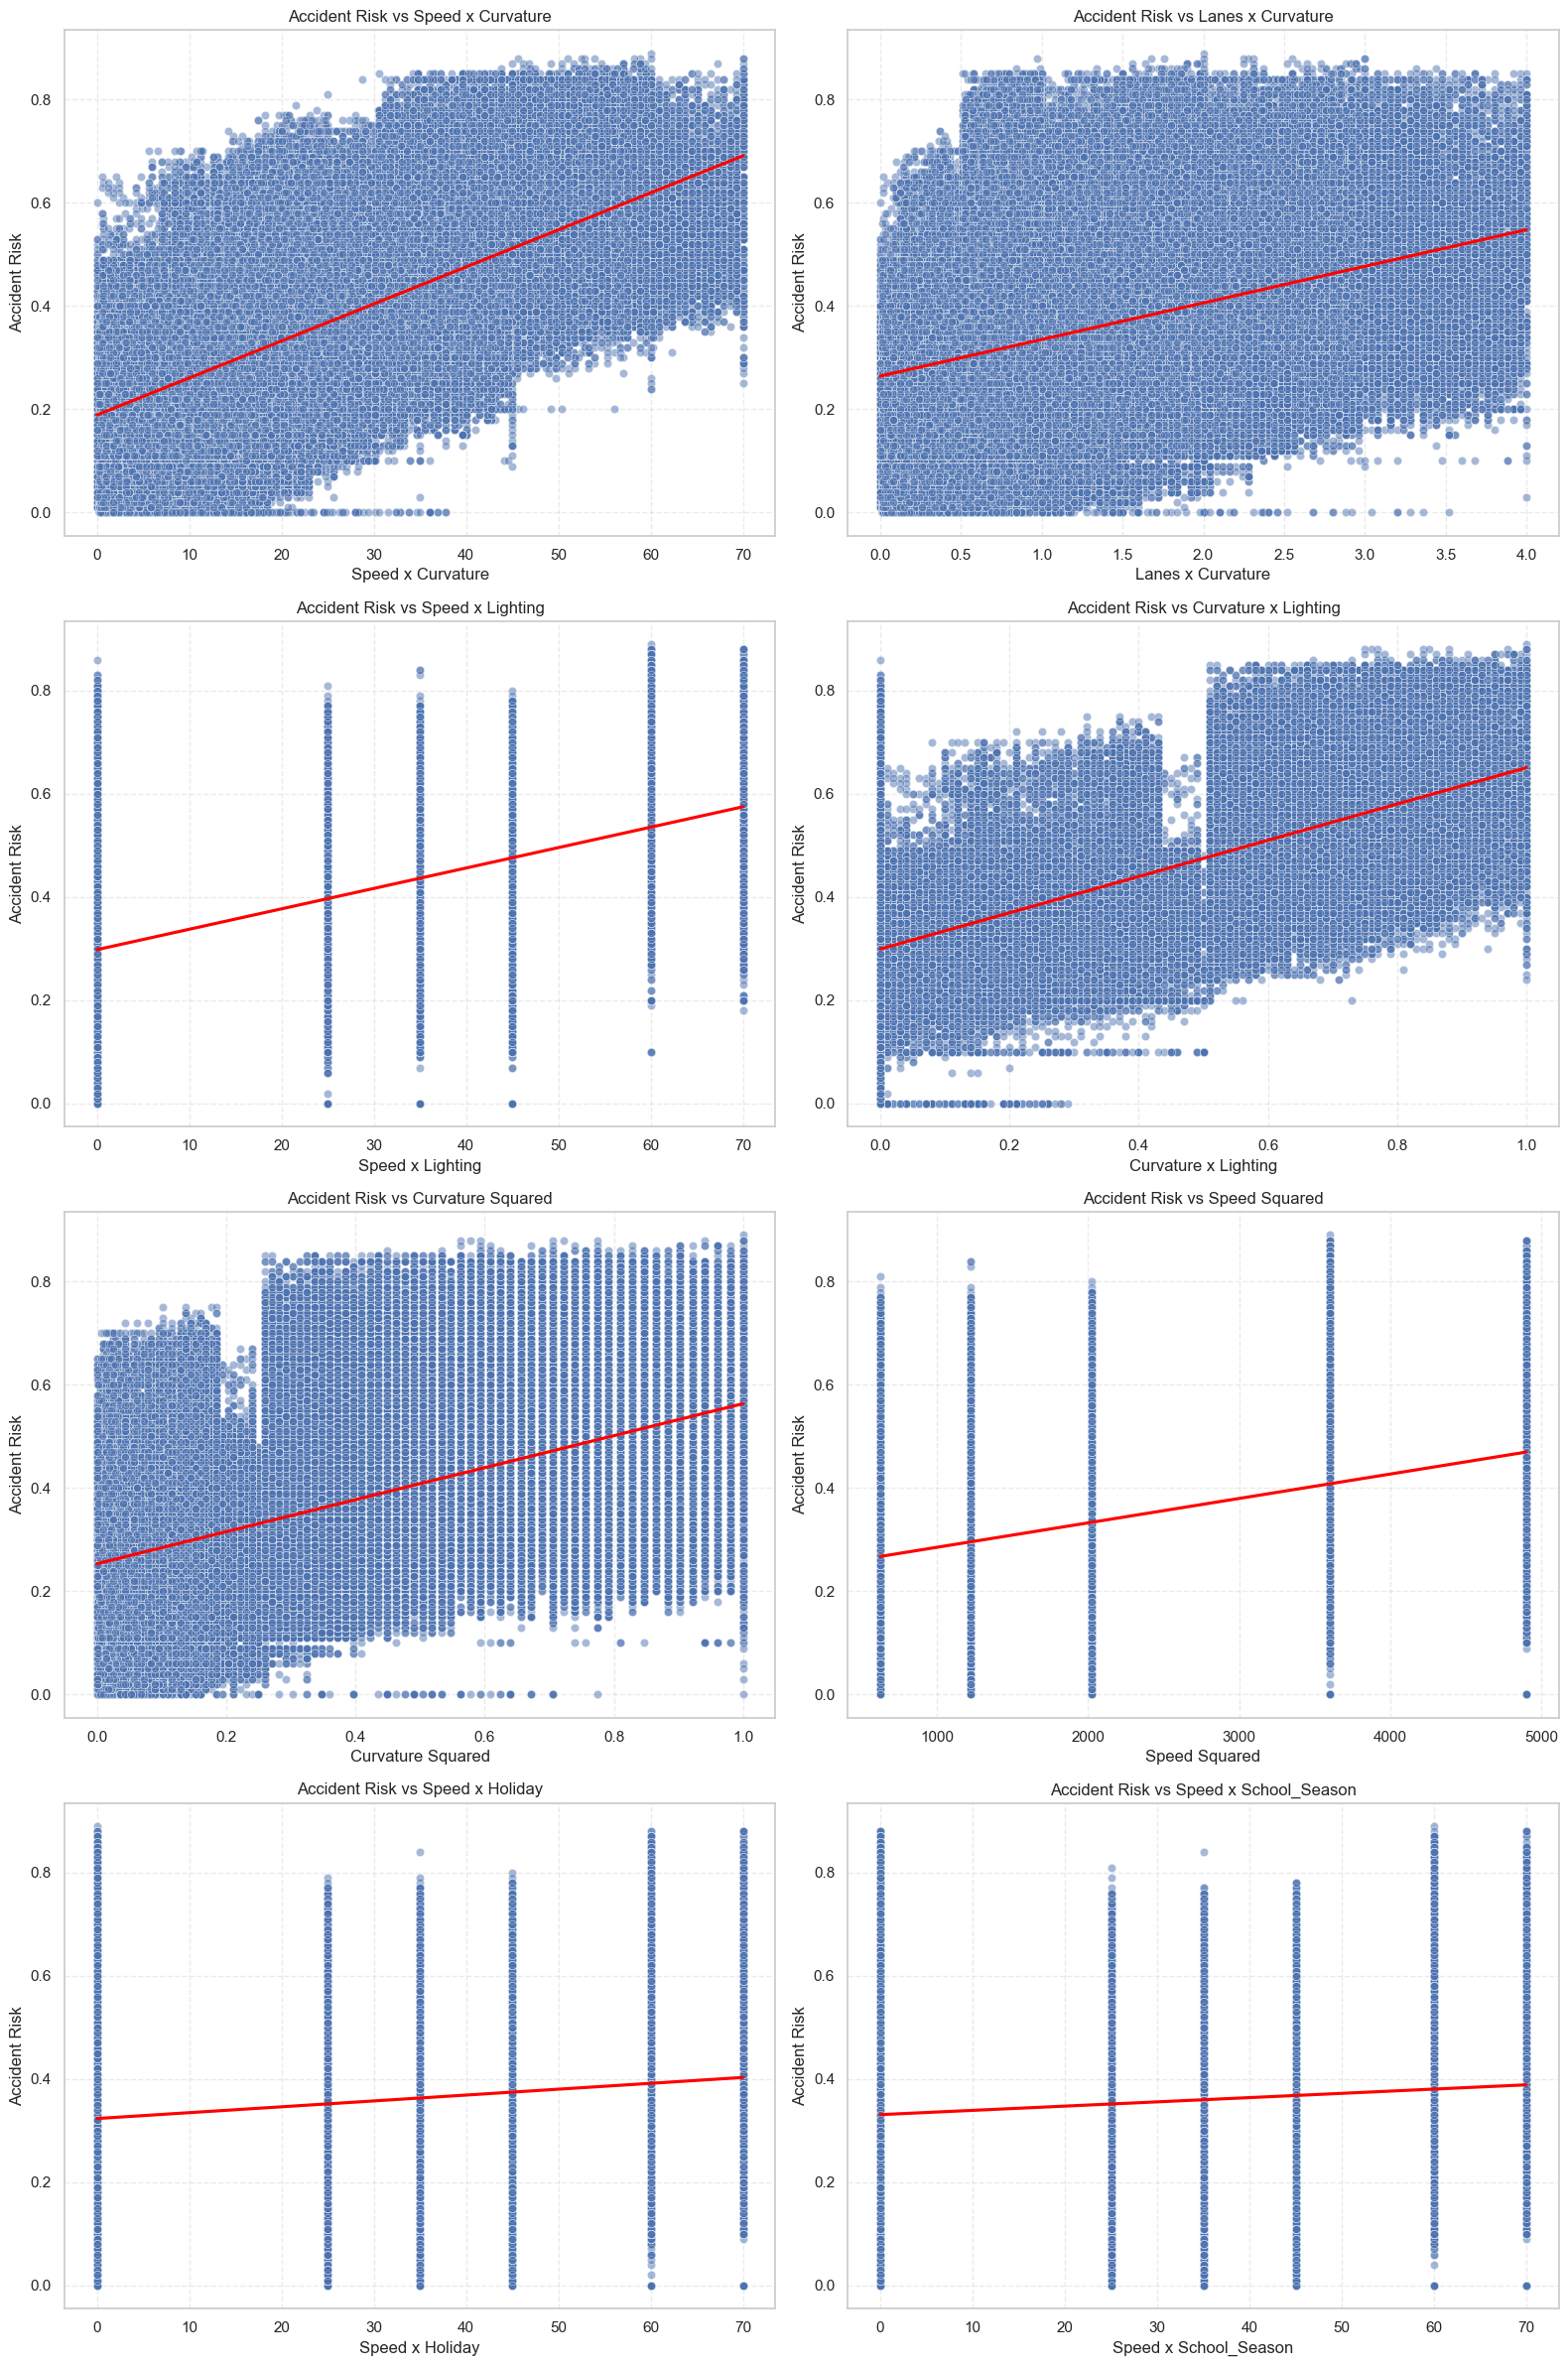

In [28]:
import math

combined_features = {
    'Speed x Curvature': clean_df['speed_limit'] * clean_df['curvature'],
    'Lanes x Curvature': clean_df['num_lanes'] * clean_df['curvature'],
    'Speed x Lighting': clean_df['speed_limit'] * clean_df['lighting_encoded'],
    'Curvature x Lighting': clean_df['curvature'] * clean_df['lighting_encoded'],
    'Curvature Squared': clean_df['curvature'] ** 2,
    'Speed Squared': clean_df['speed_limit'] ** 2,
    'Speed x Holiday': clean_df['speed_limit'] * clean_df['holiday'],
    'Speed x School_Season': clean_df['speed_limit'] * clean_df['school_season'],

}

features = combined_features
n_features = len(features)
n_cols = 2
n_rows = math.ceil(n_features / n_cols)

plt.figure(figsize=(16, 6*n_rows))

for i, (name, feature) in enumerate(features.items(), 1):
    plt.subplot(n_rows, n_cols, i)
    sns.scatterplot(x=feature, y=clean_df['accident_risk'], alpha=0.5)
    sns.regplot(x=feature, y=clean_df['accident_risk'], scatter=False, color='red')
    plt.title(f"Accident Risk vs {name}")
    plt.xlabel(name)
    plt.ylabel("Accident Risk")
    plt.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

In [29]:
for df in [clean_df, test_df]:
    df['speed_curvature'] = df['speed_limit'] * df['curvature']
    df['lanes_curvature'] = df['num_lanes'] * df['curvature']
    df['speed_lighting'] = df['speed_limit'] * df['lighting_encoded']
    df['curvature_lighting'] = df['curvature'] * df['lighting_encoded']
    df['high_speed_curve'] = ((df['speed_limit'] >= 60) & (df['curvature'] > 0.5)).astype(int)
    df['curvature_squared'] = df['curvature'] ** 2
    df['speed_squared'] = df['speed_limit'] ** 2
    df['bad_conditions'] = (((df.get('weather_rainy',0) == 1) | (df.get('weather_foggy',0) == 1)) & (df['lighting_encoded'] == 1)).astype(int)
   
for col in clean_df.columns:
    if col not in test_df.columns and col != 'accident_risk':
        test_df[col] = 0

In [30]:
num_duplicates = clean_df.duplicated().sum()
print("Number of duplicate rows:", num_duplicates)

Number of duplicate rows: 655


In [31]:
clean_df = clean_df.drop_duplicates()

In [32]:
clean_df.drop(columns=['curvature_bin'], inplace =True)

In [33]:
clean_df.head()

,num_lanes,curvature,speed_limit,lighting,road_signs_present,public_road,holiday,school_season,num_reported_accidents,accident_risk,...,time_of_day_morning,lighting_encoded,speed_curvature,lanes_curvature,speed_lighting,curvature_lighting,high_speed_curve,curvature_squared,speed_squared,bad_conditions
0,2,0.06,35,daylight,0,1,0,1,1,0.13,...,False,0,2.10,0.12,0,0.0,0,0.0036,1225,0
1,4,0.99,35,daylight,1,0,1,1,0,0.35,...,False,0,34.65,3.96,0,0.0,0,0.9801,1225,0
2,4,0.63,70,dim,0,1,1,0,2,0.30,...,True,0,44.10,2.52,0,0.0,1,0.3969,4900,0
3,4,0.07,35,dim,1,1,0,0,1,0.21,...,True,0,2.45,0.28,0,0.0,0,0.0049,1225,0
4,1,0.58,60,daylight,0,0,1,0,1,0.56,...,False,0,34.80,0.58,0,0.0,1,0.3364,3600,0


In [34]:
cat_cols = clean_df.select_dtypes(exclude=[np.number])

In [35]:
cat_cols

,lighting,weather_clear,weather_foggy,weather_rainy,road_type_highway,road_type_rural,road_type_urban,time_of_day_afternoon,time_of_day_evening,time_of_day_morning
0,daylight,False,False,True,False,False,True,True,False,False
1,daylight,True,False,False,False,False,True,False,True,False
2,dim,True,False,False,False,True,False,False,False,True
3,dim,False,False,True,True,False,False,False,False,True
4,daylight,False,True,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...
514404,daylight,False,True,False,True,False,False,True,False,False
514405,daylight,False,False,True,False,True,False,False,False,True
514406,daylight,False,True,False,False,False,True,True,False,False
514407,night,True,False,False,True,False,False,True,False,False


In [36]:
# Target column
y = train_df["accident_risk"]

# Features (remove target + id column if present)
X = train_df.drop(columns=["accident_risk", "id"], errors="ignore")


In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [38]:
bool_cols = X.select_dtypes(include=["bool"]).columns.tolist()
obj_cols  = X.select_dtypes(include=["object"]).columns.tolist()
num_cols  = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

In [39]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [40]:
preprocessor = ColumnTransformer(
    transformers=[
        ("bool", "passthrough", bool_cols),  # booleans stay as 0/1 automatically
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown='ignore'), obj_cols)
    ]
)

In [41]:
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

In [42]:
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", model)
])

In [43]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('bool', 'passthrough',
                                                  ['road_signs_present',
                                                   'public_road', 'holiday',
                                                   'school_season']),
                                                 ('num', 'passthrough',
                                                  ['num_lanes', 'curvature',
                                                   'speed_limit',
                                                   'num_reported_accidents']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['road_type', 'lighting',
                                                   'weather',
                                                   'time_of_day'])])),
                ('model',
                 XGBRegr...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=300, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [44]:
from sklearn.metrics import mean_squared_error, r2_score

In [45]:
y_pred = pipeline.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R² Score:", r2)


RMSE: 0.05624142612216775
R² Score: 0.8854456121106508


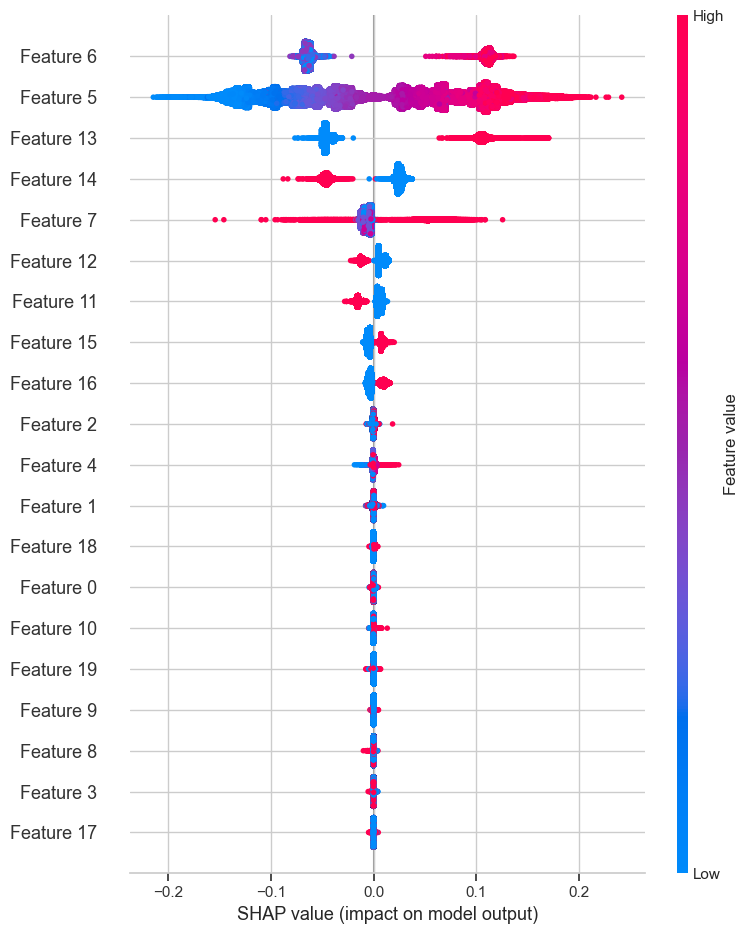

In [46]:
import shap

# 1. Extract final model from pipeline
model = pipeline.named_steps["model"]

# 2. Transform data using the pipeline's preprocessing
X_processed = pipeline.named_steps["preprocess"].transform(X_train)

# 3. Create TreeExplainer
explainer = shap.TreeExplainer(model)

# 4. Calculate shap values
shap_values = explainer.shap_values(X_processed)

# 5. Summary plot
shap.summary_plot(shap_values, X_processed)


In [47]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor

from sklearn.metrics import mean_squared_error, r2_score

In [48]:
model_xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model_rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    random_state=42
)

model_gb = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3
)

In [49]:
from sklearn.linear_model import Ridge

In [50]:

stack_model = StackingRegressor(
    estimators=[
        ("xgb", model_xgb),
        ("rf", model_rf),
        ("gb", model_gb)
    ],
    final_estimator=Ridge(alpha=1.0),
    passthrough=False
)

In [51]:
pipeline_stack = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("stack", stack_model)
])


In [52]:
pipeline_stack.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('bool', 'passthrough',
                                                  ['road_signs_present',
                                                   'public_road', 'holiday',
                                                   'school_season']),
                                                 ('num', 'passthrough',
                                                  ['num_lanes', 'curvature',
                                                   'speed_limit',
                                                   'num_reported_accidents']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['road_type', 'lighting',
                                                   'weather',
                                                   'time_of_day'])])),
                ('stack',
                 Stackin...
                                                             max_delta_step=None,
                                                             max_depth=6,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=300,
                                                             n_jobs=None,
                                                             num_parallel_tree=None, ...)),
                                               ('rf',
                                                RandomForestRegressor(max_depth=12,
                                                                      n_estimators=300,
                                                                      random_state=42)),
                                               ('gb',
                                                GradientBoostingRegressor(learning_rate=0.05,
                                                                          n_estimators=300))],
                                   final_estimator=Ridge()))])

In [53]:
y_pred = pipeline_stack.predict(X_test)

rmse_stack = np.sqrt(mean_squared_error(y_test, y_pred))
r2_stack = r2_score(y_test, y_pred)

print("RMSE:", rmse_stack)
print("R² Score:", r2_stack)

RMSE: 0.05618047426887262
R² Score: 0.8856937750459883
